<a href="https://colab.research.google.com/github/pierresegonne/ELEC5307_Project1/blob/master/project1_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UTILS

In [0]:
# Install pytorch

from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
print('Accelerator: ', accelerator)

print('Installing Torch') 
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl
# Issue with torchvision version
!pip install torchvision==0.2.1
import torch
import torchvision

Accelerator:  cpu
Installing Torch
     |████████████████████████████████| 69.4MB 50.8MB/s 
ERROR: torchvision 0.3.0 has requirement torch>=1.1.0, but you'll have torch 1.0.0 which is incompatible.
     |████████████████████████████████| 61kB 4.2MB/s 
  Found existing installation: torchvision 0.3.0
    Uninstalling torchvision-0.3.0:
      Successfully uninstalled torchvision-0.3.0


In [0]:
ROOT_DIRECTORY = '.'

In [0]:
# Allow saving files to google drive if ran on colab
from google.colab import drive
drive.mount('/content/gdrive')
ROOT_DIRECTORY = '/content/gdrive/My Drive/Colab Notebooks/ELEC5307 Project1'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# IMPORTS

In [0]:
# useful packages
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn

# OWN 
import numpy as np
import math
import matplotlib.pyplot as plt


# CODE

## 1st Influence: Data Transformation

In [33]:
"""
Modification of the transformations
Choice          Parameters
---------------------------
Center Crop     size
Five Crop       size
Resize          size + interpolation
"""
train_transform_original = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_transform_centercrop = transforms.Compose(
    [# Cropping
     transforms.CenterCrop(22),
     transforms.Resize(32),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def infocrop(crops):
    print(crops)
    return crops

def infocrop2(crops):
    print(crops.shape)
    return crops

def handleFiveCrops(crops):
    # original 
    # return torch.stack([ToTensor()(crop) for crop in crops])
    tensor_stack = []
    for crop in crops:
      new_tensor = transforms.Compose([
                                       transforms.Resize(32),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ])(crop)
      tensor_stack.append(new_tensor)
    return torch.stack(tensor_stack)

train_transform_fivecrop = transforms.Compose(
    [# Cropping
     transforms.FiveCrop(22),
     # transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
     transforms.Lambda(lambda crops: handleFiveCrops(crops)),
     ])


train_transform = train_transform_fivecrop

test_transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


torch.Size([20, 3, 32, 32])
plane   dog horse  frog


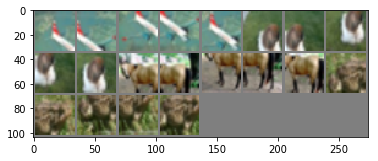

In [34]:
def showimg(tensor):
    tensor = tensor / 2 + 0.5     # unnormalize, because normalization is (img - 0.5)/0.5 in transforms.Normalize
    npimg = tensor.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Visualization of random training images
dataiter = trainloader.__iter__()
input, labels = dataiter.next()

bs, ncrops, c, h, w = input.size()
input = input.view(-1, c, h, w) # fuse crops and bs
print(input.shape)
# show images
showimg(torchvision.utils.make_grid(input))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

##2nd Influence: Network Structure

In [0]:
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # define the network layers

        # nn.Conv2d(input_channel, output_channel, filter_size,
        #     stride=stride, padding=padding)
        # By default, padding=0, stride=1
        # CIFAR 10 is 32*32*3
        # Pooling Method, Kernel size, dropout and activation method shall not be experimented with.

        # .,3,32,32
        self.conv1 = nn.Conv2d(3,32,5) 
        # .,32,28,28
        self.pool1 = nn.MaxPool2d(2,2)
        # .,32,14,14
        self.conv2 = nn.Conv2d(32,64,5)
        # .,64,10,10
        self.pool2 = nn.MaxPool2d(2,2)
        # .,64,5,5
        self.conv3 = nn.Conv2d(64,128,5)
        # .,128,1,1
        self.pool3 = nn.MaxPool2d(2,2)
        # .,128,1,1

        self.fc1 = nn.Linear(128,80)
        self.fc2 = nn.Linear(80,64)
        self.fc3 = nn.Linear(64,10)

    def forward(self, x):
        # define the network structure
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        # Reshape
        x = x.view(-1,128)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

cnn = CNN()

# test
# REMINDER, shape of tensor: [BS, CH, HEIGHT, WIDTH]
input = torch.rand((1,3,32,32))
cnn(input)

tensor([[-0.0137,  0.1034,  0.0817, -0.0291,  0.0973,  0.1218, -0.0430,  0.0280,
          0.0175,  0.1489]], grad_fn=<AddmmBackward>)

## 3rd Influence: Optimizer

https://arxiv.org/pdf/1506.01186.pdf cyclical lr -> implementation

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

def cyclical_learning_rate(min_lr, max_lr, stepsize, mode='triangular'):
  cycle = math.floor(1+(iteration/2*stepsize))
  if mode == 'triangular':
    scaler = lambda x: 1
  if mode == 'triangular2':
    scaler = lambda x: (1/2)**(x-1)

  lr_scheduler = lambda iteration: min_lr + (max_lr - min_lr)*eval(iteration, stepsize)

# What about exp? Shown not to yield significantly better results, more complex to implement so didn't

  def eval(iteration, stepsize):
    cycle = math.floor(1+(iteration/stepsize))
    x = abs(iteration/stepsize - 2*cycle +1)
    return max(0,(1-x))*scaler(cycle)

  return lr_scheduler


# baseline
lambdaCLR = lambda iteration : iteration
# CLR
lambdaCLR = cyclical_learning_rate(0.001, 0.006, (tr_set_size/bs * 4))
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambdaCLR)

NameError: ignored

In [4]:
abs(23 / 10 - 2 * 3 + 1)

2.7